Link to csv file:
https://catalog.data.gov/dataset/real-estate-sales-2001-2018

In [1]:
                                                                                  from google.colab import files
uploaded = files.upload()

Saving Real_Estate_Sales_2001-2022_GL.csv to Real_Estate_Sales_2001-2022_GL.csv


# Benchmark 1: Implementation of ARIMA, SARIMA, and LTSM.

NaN values in time series data: 27
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0267
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0090
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0047
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0027
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086

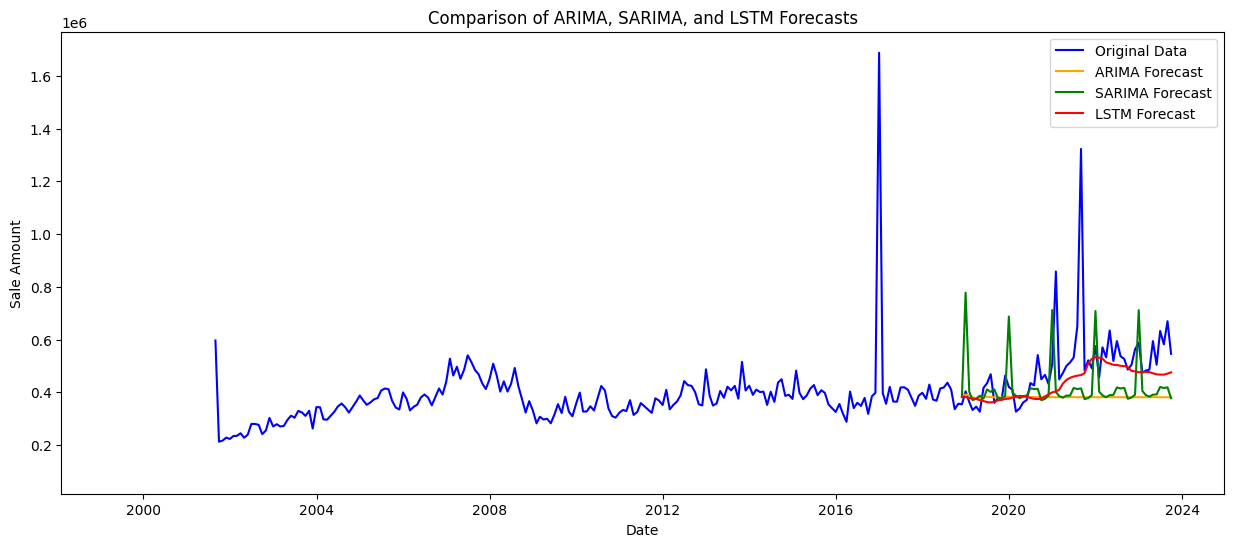

ARIMA RMSE: 187245.35
SARIMA RMSE: 185485.60
LSTM RMSE: 145652.79


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import numpy as np
from sklearn.metrics import mean_squared_error

# Define explicit data types for each column
dtype_dict = {
    'Serial Number': 'int64',
    'List Year': 'int64',
    'Date Recorded': 'str',
    'Town': 'str',
    'Address': 'str',
    'Assessed Value': 'float64',
    'Sale Amount': 'float64',
    'Sales Ratio': 'float64',
    'Property Type': 'str',
    'Residential Type': 'str',
    'Non Use Code': 'str',
    'Assessor Remarks': 'str',
    'OPM remarks': 'str',
    'Location': 'str'
}

# Load the dataset with specified data types
file_path = 'Real_Estate_Sales_2001-2022_GL.csv'
data = pd.read_csv(file_path, dtype=dtype_dict)

# Convert 'Date Recorded' to datetime and set as index
data['Date Recorded'] = pd.to_datetime(data['Date Recorded'], format='%m/%d/%Y', errors='coerce')
data.set_index('Date Recorded', inplace=True)

# Select the target variable (for example, Sale Amount)
target = 'Sale Amount'

# Drop rows with NaN values in the target variable
data.dropna(subset=[target], inplace=True)

# Resample the data to month-end frequency and check for NaNs
time_series_data = data[target].resample('ME').mean().dropna()
time_series_data = time_series_data.asfreq('ME')

# Check for NaN values in the time series data
print(f'NaN values in time series data: {time_series_data.isnull().sum()}')

# Split the data into training and testing sets
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))

# LSTM Model
# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data.values.reshape(-1, 1))

# Ensure there are no NaNs in scaled data
scaled_data = np.nan_to_num(scaled_data)  # Replace NaNs with 0

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split the LSTM data
X_train, X_test = X[:-len(test)], X[-len(test):]
y_train, y_test = y[:-len(test)], y[-len(test):]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))  # Output layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast with LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Inverse scaling

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast', color='red')
plt.title('Comparison of ARIMA, SARIMA, and LSTM Forecasts')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
lstm_rmse = np.sqrt(mean_squared_error(test, lstm_forecast))

print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')
print(f'LSTM RMSE: {lstm_rmse:.2f}')

# Benchmark 2: Implemented pmdarima's auto_arima function for both ARIMA and SARIMA in order to automatically find best parameters for the models.

In [ ]:
!pip install pmdarima

NaN values in time series data: 27
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5497.203, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5451.951, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5391.714, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5495.222, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5393.206, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5395.432, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5395.640, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5390.473, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5392.026, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5391.885, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5449.909, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5393.788, Time=0.66 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.943 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=12.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5497.203, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5453.950, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5393.587, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5495.222, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5391.714, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5393.571, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5395.529, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5393.206, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=5395.432, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5451.951, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5395.640, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=5390.473, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=5392.371, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0260
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0054
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0057
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

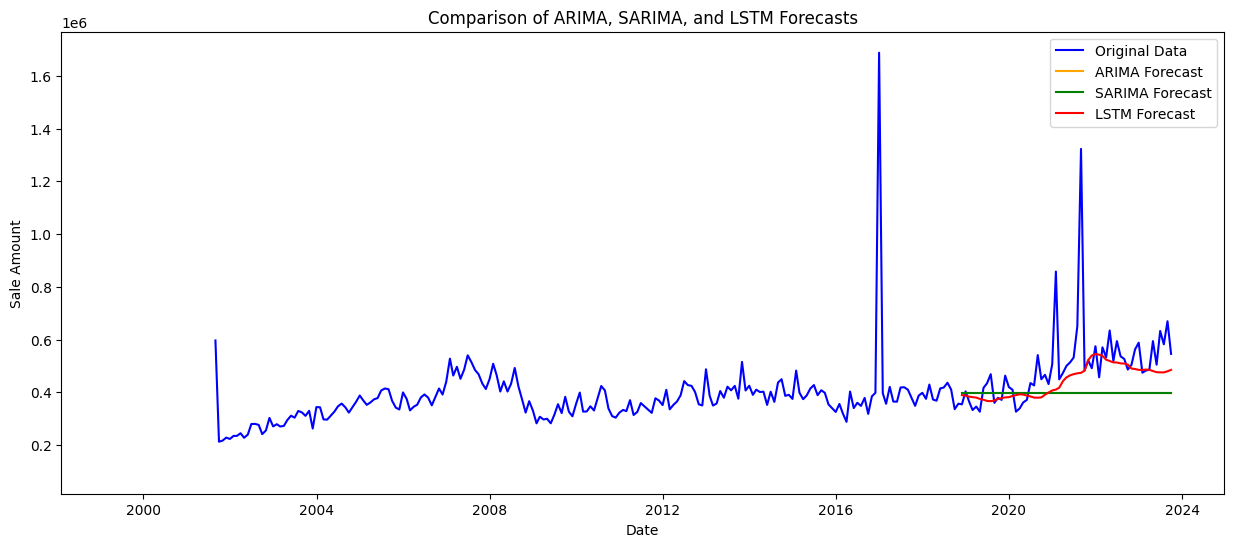

ARIMA RMSE: 178615.79
SARIMA RMSE: 178615.79
LSTM RMSE: 142398.41


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import numpy as np
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Define explicit data types for each column
dtype_dict = {
    'Serial Number': 'int64',
    'List Year': 'int64',
    'Date Recorded': 'str',
    'Town': 'str',
    'Address': 'str',
    'Assessed Value': 'float64',
    'Sale Amount': 'float64',
    'Sales Ratio': 'float64',
    'Property Type': 'str',
    'Residential Type': 'str',
    'Non Use Code': 'str',
    'Assessor Remarks': 'str',
    'OPM remarks': 'str',
    'Location': 'str'
}

# Load the dataset with specified data types
file_path = 'Real_Estate_Sales_2001-2022_GL.csv'
data = pd.read_csv(file_path, dtype=dtype_dict)

# Convert 'Date Recorded' to datetime and set as index
data['Date Recorded'] = pd.to_datetime(data['Date Recorded'], format='%m/%d/%Y', errors='coerce')
data.set_index('Date Recorded', inplace=True)

# Select the target variable (for example, Sale Amount)
target = 'Sale Amount'

# Drop rows with NaN values in the target variable
data.dropna(subset=[target], inplace=True)

# Resample the data to month-end frequency and check for NaNs
time_series_data = data[target].resample('ME').mean().dropna()
time_series_data = time_series_data.asfreq('ME')

# Check for NaN values in the time series data
print(f'NaN values in time series data: {time_series_data.isnull().sum()}')

# Split the data into training and testing sets
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# Drop any remaining NaN values in the train data before fitting auto_arima
train = train.dropna()

# Auto ARIMA model
auto_arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
best_arima_order = auto_arima_model.order
print(f'Best ARIMA order: {best_arima_order}')

# Fit ARIMA model with the best order
arima_model = ARIMA(train, order=best_arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# Auto SARIMA model
auto_sarima_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
best_sarima_order = auto_sarima_model.order
best_seasonal_order = auto_sarima_model.seasonal_order
print(f'Best SARIMA order: {best_sarima_order}, Seasonal order: {best_seasonal_order}')

# Fit SARIMA model with the best order and seasonal order
sarima_model = SARIMAX(train, order=best_sarima_order, seasonal_order=best_seasonal_order)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))

# LSTM Model
# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data.values.reshape(-1, 1))

# Ensure there are no NaNs in scaled data
scaled_data = np.nan_to_num(scaled_data)  # Replace NaNs with 0

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split the LSTM data
X_train, X_test = X[:-len(test)], X[-len(test):]
y_train, y_test = y[:-len(test)], y[-len(test):]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))  # Output layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast with LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Inverse scaling

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast', color='red')
plt.title('Comparison of ARIMA, SARIMA, and LSTM Forecasts')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
lstm_rmse = np.sqrt(mean_squared_error(test, lstm_forecast))

print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')
print(f'LSTM RMSE: {lstm_rmse:.2f}')


# Benchmark 3: Implemented interpolation along with deletion to deal with NaN values

NaN values in time series data after interpolation: 0
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6087.728, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6170.606, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6120.686, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6083.120, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6168.626, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6084.798, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6084.676, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6086.414, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6081.230, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6082.755, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6082.551, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6118.740, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6080.755, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=608

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6091.528, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6170.606, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6122.679, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6085.066, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6168.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6083.120, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=6085.050, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6086.866, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6084.798, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=6084.676, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6120.686, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6086.414, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=6081.230, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=6083.166, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0285
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0089
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0062
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━

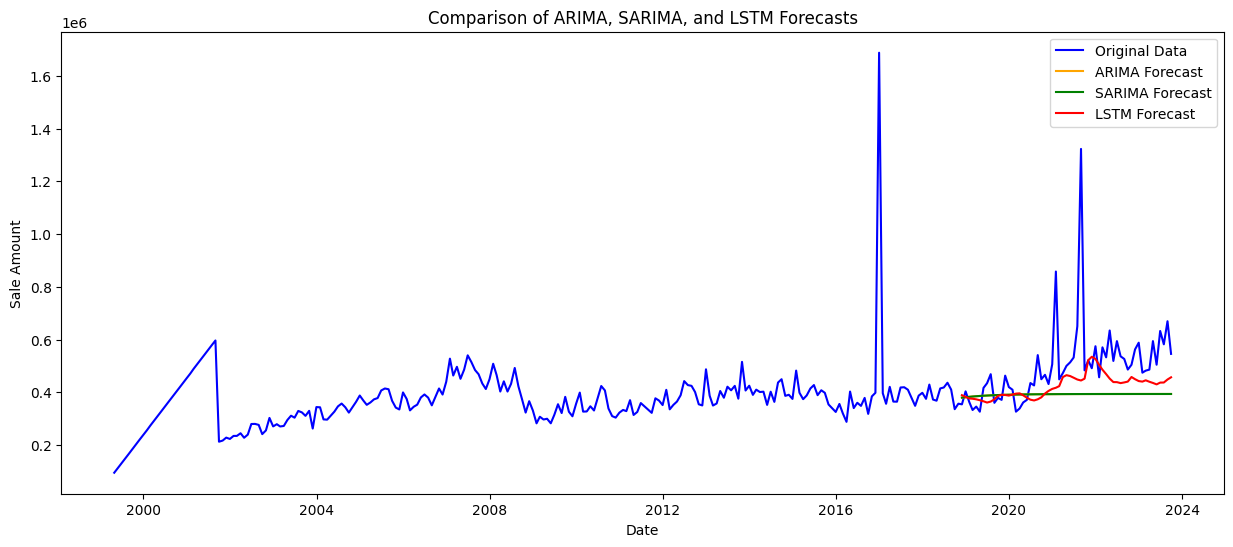

ARIMA RMSE: 180026.63
SARIMA RMSE: 180026.63
LSTM RMSE: 154214.27


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import numpy as np
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Define explicit data types for each column
dtype_dict = {
    'Serial Number': 'int64',
    'List Year': 'int64',
    'Date Recorded': 'str',
    'Town': 'str',
    'Address': 'str',
    'Assessed Value': 'float64',
    'Sale Amount': 'float64',
    'Sales Ratio': 'float64',
    'Property Type': 'str',
    'Residential Type': 'str',
    'Non Use Code': 'str',
    'Assessor Remarks': 'str',
    'OPM remarks': 'str',
    'Location': 'str'
}

# Load the dataset with specified data types
file_path = 'Real_Estate_Sales_2001-2022_GL.csv'
data = pd.read_csv(file_path, dtype=dtype_dict)

# Convert 'Date Recorded' to datetime and set as index
data['Date Recorded'] = pd.to_datetime(data['Date Recorded'], format='%m/%d/%Y', errors='coerce')
data.set_index('Date Recorded', inplace=True)

# Select the target variable (for example, Sale Amount)
target = 'Sale Amount'

# Drop rows with NaN values in the target variable
data.dropna(subset=[target], inplace=True)

# Resample the data to month-end frequency and fill any remaining NaNs with interpolation
time_series_data = data[target].resample('ME').mean()
time_series_data = time_series_data.interpolate(method='linear').dropna()

# Check for NaN values in the time series data (should be zero after this step)
print(f'NaN values in time series data after interpolation: {time_series_data.isnull().sum()}')

# Split the data into training and testing sets
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# Auto ARIMA model
auto_arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
best_arima_order = auto_arima_model.order
print(f'Best ARIMA order: {best_arima_order}')

# Fit ARIMA model with the best order
arima_model = ARIMA(train, order=best_arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# Auto SARIMA model
auto_sarima_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
best_sarima_order = auto_sarima_model.order
best_seasonal_order = auto_sarima_model.seasonal_order
print(f'Best SARIMA order: {best_sarima_order}, Seasonal order: {best_seasonal_order}')

# Fit SARIMA model with the best order and seasonal order
sarima_model = SARIMAX(train, order=best_sarima_order, seasonal_order=best_seasonal_order)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))

# LSTM Model
# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data.values.reshape(-1, 1))

# Ensure there are no NaNs in scaled data
scaled_data = np.nan_to_num(scaled_data)  # Replace NaNs with 0

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split the LSTM data
X_train, X_test = X[:-len(test)], X[-len(test):]
y_train, y_test = y[:-len(test)], y[-len(test):]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))  # Output layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast with LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Inverse scaling

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast', color='red')
plt.title('Comparison of ARIMA, SARIMA, and LSTM Forecasts')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
lstm_rmse = np.sqrt(mean_squared_error(test, lstm_forecast))

print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')
print(f'LSTM RMSE: {lstm_rmse:.2f}')
